## Autonomous Masking with Classification 
This notebook demonstrates autonomous channel masking and spike masking. 

### Part I: channel masking

In [1]:
from miv.signal.classification.abnormality_detection import DetectorWithTrainData, DetectorWithSpontaneousData
from miv.io.data import Data, DataManager

from miv.signal.spike import ThresholdCutoff, PCADecomposition
from miv.signal.filter import ButterBandpass
from miv.visualization import extract_waveforms

from viziphant.rasterplot import rasterplot_rates

import matplotlib.pyplot as plt
import numpy as np
import quantities as pq


datapath: str = "./docs/discussion/spike_classification/2022-03-10_16-19-09/"
train_datapath: str = "./docs/discussion/spike_classification/train_data_00.npz"

spike_detector = ThresholdCutoff()
band_filter = ButterBandpass(300, 3000)
pca = PCADecomposition()

data_manager = DataManager(datapath)

We first graph out experiment 2 as reference:

100%|██████████| 64/64 [00:02<00:00, 26.84it/s]


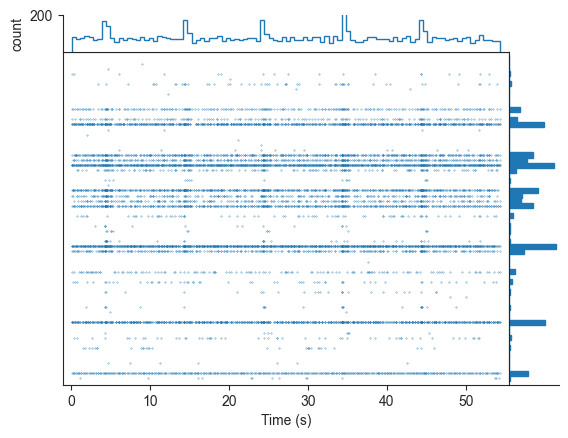

In [2]:
with data_manager[1].load() as (sig, times, samp):
    filtered_sig = band_filter(sig, samp)
    original_spikes = spike_detector(filtered_sig, times, samp)
    del filtered_sig

rasterplot_rates(original_spikes, markerargs={'marker':'.','markersize': 0.5})
plt.show()

The auto_channel_mask_with_firing_rate function filters out channels that have firing rates below a set threshold. We will set this to 0.01 spike/second for now:

100%|██████████| 18/18 [00:00<00:00, 26.77it/s]


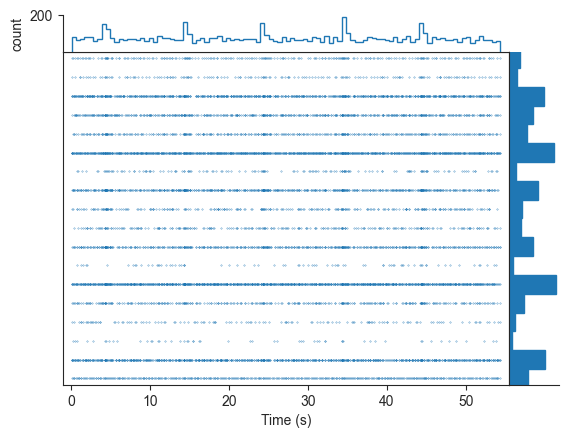

In [3]:
data_manager.auto_channel_mask_with_firing_rate(filter=band_filter, detector=spike_detector, no_spike_threshold=0.01)

with data_manager[1].load() as (sig, times, samp):
    filtered_sig = band_filter(sig, samp)
    channel_filtered_spikes = spike_detector(filtered_sig, times, samp)
    del filtered_sig

rasterplot_rates(channel_filtered_spikes, markerargs={'marker':'.','markersize': 0.5})
plt.show()

Even though this may look cleaner, it is difficult to determine how effective this is. Channels may have very few spikes but all of which can be neuronal. Channels may also have constant noise spikes.

I also experimented with a few other statistical measures instead of firing rate. They did not seem to perform as well as firing rate.

Since we have a spontaneous recording, we can use that data to compare. The auto_channel_mask_with_correlation_matrix function bins the spike count of each channel with respect to time, then compares it with the binned spike count from the spontaneous recording.

100%|██████████| 39/39 [00:01<00:00, 25.00it/s]


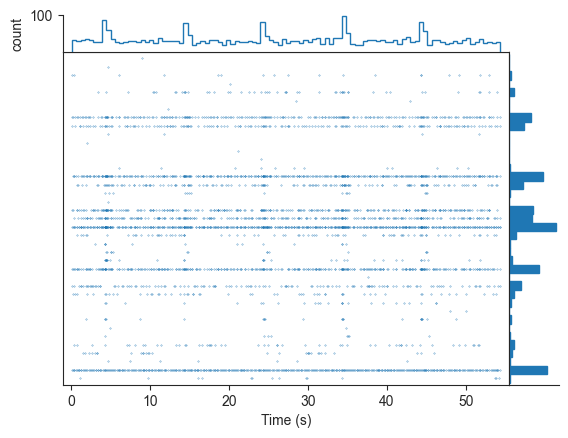

In [4]:
for data in data_manager:
    data.clear_channel_mask()

data_manager.auto_channel_mask_with_correlation_matrix(
    spontaneous_data=data_manager[0],
    filter=band_filter,
    detector=spike_detector,
    omit_experiments=[0]
)

with data_manager[1].load() as (sig, times, samp):
    filtered_sig = band_filter(sig, samp)
    channel_filtered_spikes = spike_detector(filtered_sig, times, samp)
    del filtered_sig

rasterplot_rates(channel_filtered_spikes, markerargs={'marker':'.','markersize': 0.5})
plt.show()

This method does mask out channels, but without a closer look at whether the remaining channels are good channels, we can't determine if the outcome is desireable.

### Part II: spike filtering
Instead of masking out entire channels, we can look at each individual spike and determine if it is noise.

The neuronal_spike_classifier class is built as a wrapper to a machine learning model. It contains some useful functions for ease in creating, compiling, and fitting the model.

There are 2 abnormality detector classes: the first is DetectorWithSpontaneousData. This detector integrates the data and data manager format with the classifier. 

First, spike cutouts are obtained. Then, a feature extractor is used to categorized these spike cutouts. Because it is extremely tedious to label each individual spike, spontaneous spike cutout categories would need to be labeled. The idea is to apply the label to each spike in the category, then train the model from there.

In [5]:
for data in data_manager:
    data.clear_channel_mask()
    
abn_detector_spont = DetectorWithSpontaneousData(
    spontaneous_data=data_manager[0],
    spontaneous_signal_filter=band_filter,
    spontaneous_spike_detector=spike_detector,
    spike_feature_extractor=pca
)

100%|██████████| 64/64 [00:05<00:00, 11.28it/s]


The issue with this method lies in the categorization. Spikes in the same category often have a large variety. Shown here is all the spikes in category 1 from the spontaneous recording:

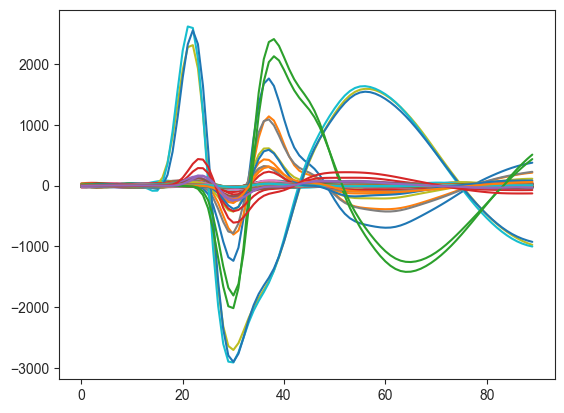

In [6]:
spont_cutouts_by_components = abn_detector_spont.get_spontaneous_cutouts_by_components()
for cutout in spont_cutouts_by_components[1]:
    plt.plot(cutout)
plt.show()

Instead of having someone label these spikes every time, it may be better to use a labeling file to train the model. DetectorWithTrainData is built to train a model with a file, classify spikes, and then keep only the neuronal spikes.

In [7]:
abn_detector_train_file = DetectorWithTrainData(train_datapath=train_datapath)
abn_detector_train_file.init_classifier()
abn_detector_train_file.default_compile_and_train(train_ratio=1)

Epoch 1/5
6343/6343 [==============================] - 10s 1ms/step - loss: 1.0458 - accuracy: 0.8007
Epoch 2/5
6343/6343 [==============================] - 9s 1ms/step - loss: 0.5375 - accuracy: 0.8155
Epoch 3/5
6343/6343 [==============================] - 9s 1ms/step - loss: 0.5477 - accuracy: 0.8166
Epoch 4/5
6343/6343 [==============================] - 9s 1ms/step - loss: 0.5358 - accuracy: 0.8136
Epoch 5/5
6343/6343 [==============================] - 9s 1ms/step - loss: 0.5374 - accuracy: 0.8127


Using the newly trained model, the function keep_only_neuronal_spikes_from_data returns new spiketrains:

100%|██████████| 64/64 [00:02<00:00, 27.03it/s]
c:\Users\jiyug\Unsynched_Docs\MiV\venv\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


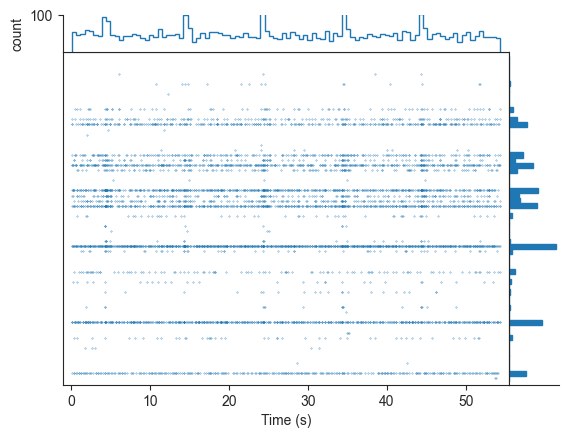

In [8]:
neuronal_spiketrains = abn_detector_train_file.keep_only_neuronal_spikes_from_data(
    experiment_data=data_manager[1],
    signal_filter=band_filter,
    spike_detector=spike_detector
)
rasterplot_rates(neuronal_spiketrains, markerargs={'marker':'.','markersize': 0.5})
plt.show()

When compared to the original spiketrains, it is clear that some channels' spikes have been eliminated. However, it is hard to determine whether this method produces useful results. 

There are still flaws with this method. It is difficult to determine a pre and post value for spike cutout waveform extraction. Extracting too short or too long will undoubtedly skew the results of spike classification.

### Part III: Some comments and suggestions for future improvement

I believe it is still possible and potentially convenient to use the detector with spontaneous data, provided that there is a capable spike feature extractor. If we can automatically classify spikes into groups and then label by each group and possibly hand-pick out the spikes that don't belong, it is much faster to classify these groups altogether, instead of spike by spike.

It would be nice to have extract_waveforms function be able to extrapolate points from the signal data if the sample rate and spike width is not consistent between train data and experimental data.

It is still necessary to examine the spikes and analyze the robustness of the classification model. It may be useful to create a model optimizer/tweaker module to experiment with different models and determine a better one.